In [42]:
%reload_ext autoreload
%autoreload 2

import time

import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from mades import MADE, MADE_MOG
from mafs import MAF, MAF_MOG

from torch.utils.data import TensorDataset, DataLoader

%config InlineBackend.figure_formats = ['svg']

## Data

In [61]:
potential_func_name = "U3"

In [62]:
data = torch.from_numpy(np.load(f"2d_data/{potential_func_name}_samples_10000.npy"))

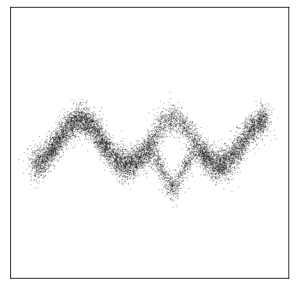

In [63]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], s=0.01, color="black")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xticks([])
plt.yticks([])
plt.show()

## MADE

In [8]:
made = MADE(data_dim=2, hidden_dims=[100, 100])
opt = optim.Adam(made.parameters(), lr=1e-3)

start_time = time.perf_counter()

for i in range(1, 10001):

    loss = - made.log_prob(data).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

    if (i % 100) == 0:
        curr_time = time.perf_counter()
        print(i, float(loss), curr_time - start_time)
        start_time = time.perf_counter()

100 5.435001373291016 1.2517024590000005
200 4.696734428405762 1.2190184160000115
300 4.256409168243408 1.220966875000002
400 3.992884874343872 1.2948755000000034
500 3.794900894165039 1.627302874999998
600 3.6429696083068848 1.4759254169999991
700 3.523860454559326 1.2426733749999954


[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [12]:
xs = torch.linspace(-6, 6, 100)
ys = torch.linspace(-6, 6, 100)
xxs, yys = torch.meshgrid(xs, ys)
xxs_flat, yys_flat = xxs.reshape(-1, 1), yys.reshape(-1, 1)
grid = torch.hstack([xxs_flat, yys_flat])

/Users/zhihanyang/opt/miniconda3/envs/mlp/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


([], [])

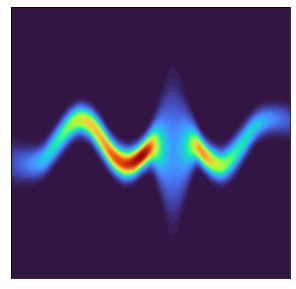

In [159]:
with torch.no_grad():
    probs = made.log_prob(grid).exp()

plt.figure(figsize=(5, 5))
plt.contourf(xxs.numpy(), yys.numpy(), probs.numpy().reshape(100, 100), levels=100, cmap="turbo")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xticks([])
plt.yticks([])
#plt.savefig(f"./saved/made_2d_density_estimation/{potential_func_name}_gaussian_made.png", dpi=300, bbox_inches='tight')

## Mixture of Gaussians MADE

In [38]:
made_mog = MADE_MOG(data_dim=2, hidden_dims=[100, 100], num_components=10)
opt = optim.Adam(made_mog.parameters(), lr=1e-3)

start_time = time.perf_counter()

for i in range(1, 10001):

    loss = -made_mog.log_prob(data).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

    if (i % 100) == 0:
        curr_time = time.perf_counter()
        print(i, float(loss), curr_time - start_time)
        start_time = time.perf_counter()

100 5.151761531829834 1.853985499999908
200 4.634710788726807 1.8688440420000916
300 4.2382001876831055 1.8914288749999741
400 3.9518535137176514 1.8448235420000856
500 3.7436442375183105 1.8939674580001338
600 3.5842230319976807 1.873681999999917
700 3.4588987827301025 1.8811838330000228
800 3.360271453857422 1.8497971249998955
900 3.2831928730010986 1.9697912910000923
1000 3.2210090160369873 1.8730407919999834
1100 3.1711645126342773 1.8781319170000188
1200 3.1317062377929688 1.9113686250000228
1300 3.099362850189209 1.9180069579999781
1400 3.0738415718078613 1.8818951670000388
1500 3.0532939434051514 1.8893022919999112
1600 3.039109468460083 1.9352989159999652
1700 3.0235748291015625 1.886195042000054
1800 3.0136208534240723 1.8784529580000253
1900 3.0048375129699707 1.9337587080001413
2000 2.998246908187866 1.8981699159999152


KeyboardInterrupt: 

([], [])

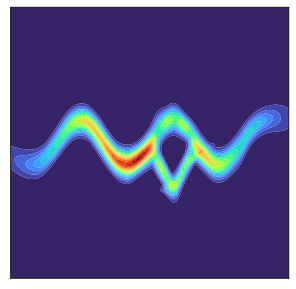

In [37]:
with torch.no_grad():
    probs = made_mog.log_prob(grid).exp()
    # means, log_stds, log_pis = mog_made.calc_mu_and_log_std_and_log_pi(torch.vstack([xs, ys]).T)
    # means = means[:, 1]

plt.figure(figsize=(5, 5))

plt.contourf(
    xxs.numpy(), yys.numpy(), probs.numpy().reshape(100, 100),
    levels=20, cmap="turbo", extent=[-5, 9, -7.5, 7.5]
)

plt.xticks([])
plt.yticks([])

#plt.savefig(f"./saved/made_2d_density_estimation/{potential_func_name}_mog_c10_made.png", dpi=300, bbox_inches='tight')

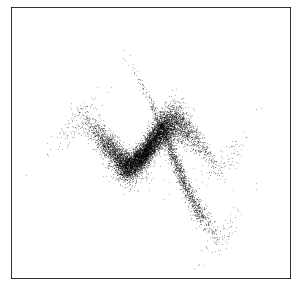

In [12]:
plt.figure(figsize=(5, 5))

with torch.no_grad():
    samples = mog_made.sample(10000).numpy()

plt.scatter(samples[:, 0], samples[:, 1], color="black", s=0.01)

plt.xlim(-6, 6)
plt.ylim(-6, 6)

plt.xticks([])
plt.yticks([])

plt.show()

## MAF(5)

In [64]:
train_ds = TensorDataset(data[:8000])
train_dl = DataLoader(train_ds, batch_size=100)

In [188]:
maf = MAFOnGaussian(data_dim=2, hidden_dims=[100, 100], num_ar_layers=10)

In [183]:
maf = MAFOnGaussian(data_dim=2, hidden_dims=[100, 100], num_ar_layers=10, reverse_input_order=False)

In [65]:
maf = MADE_MOG(data_dim=2, hidden_dims=[100, 100], num_components=10)
opt = optim.Adam(maf.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100, 200], gamma=1/3)

losses_epoch = []

for i in range(300):
    
    losses_batch = []

    for (xb, ) in train_dl:
    
        loss = - maf.log_prob(xb).mean()
        
        losses_batch.append(float(loss))
        
        opt.zero_grad()
        loss.backward()
        opt.step()

    losses_batch_mean = np.mean(losses_batch)
    print(i+1, losses_batch_mean)
    losses_epoch.append(losses_batch_mean)
    
    scheduler.step()

1 6.031325161457062
2 5.290305739641189
3 4.71892478466034
4 4.401891380548477
5 4.150279513001442
6 3.9507094383239747
7 3.792197236418724
8 3.6636610209941862
9 3.5582844734191896
10 3.4710752189159395
11 3.399240916967392
12 3.3394817292690275
13 3.288901671767235
14 3.2463280737400053
15 3.2102779388427733
16 3.1794927567243576
17 3.1530943751335143
18 3.1306860566139223
19 3.111575257778168
20 3.0954649955034257
21 3.081902825832367
22 3.0703731209039686
23 3.060612627863884
24 3.0523484259843827
25 3.0453443735837937
26 3.0394141227006912
27 3.0344047635793685
28 3.030181121826172
29 3.0266249388456345
30 3.0236325353384017
31 3.021109715104103
32 3.0189758360385897
33 3.0171682119369505
34 3.0156370520591738
35 3.014346757531166
36 3.0132534354925156
37 3.0122771948575973
38 3.0113966822624207
39 3.0106109380722046
40 3.0099070250988005
41 3.0092219710350037
42 3.008559912443161
43 3.0079890459775926
44 3.0074537068605425
45 3.0069133937358856
46 3.006453788280487
47 3.006071770

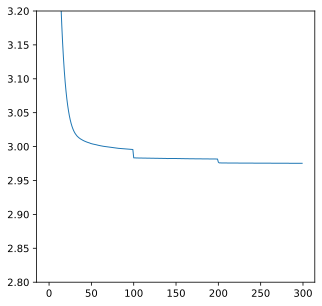

In [66]:
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(losses_epoch)), losses_epoch, linewidth=1)
plt.ylim(2.8, 3.2)
plt.show()

In [67]:
with torch.no_grad():
    ms, vs = maf.get_ms_and_vs(data)
    probs = maf.log_prob(grid, ms=ms, vs=vs).exp()

plt.figure(figsize=(5, 5))

plt.contourf(
    xxs.numpy(), yys.numpy(), probs.numpy().reshape(100, 100),
    levels=100, cmap="turbo", extent=[-5, 9, -7.5, 7.5]
)

plt.xticks([])
plt.yticks([])

#plt.savefig(f"./saved/made_2d_density_estimation/{potential_func_name}_mog_c10_made.png", dpi=300, bbox_inches='tight')
plt.savefig(f"./saved/2d_density_estimation/{potential_func_name}_maf.png", dpi=300, bbox_inches="tight")

AttributeError: 'MADE_MOG' object has no attribute 'get_ms_and_vs'

([], [])

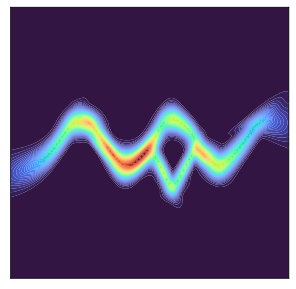

In [68]:
with torch.no_grad():
    probs = maf.log_prob(grid).exp()

plt.figure(figsize=(5, 5))

plt.contourf(
    xxs.numpy(), yys.numpy(), probs.numpy().reshape(100, 100),
    levels=100, cmap="turbo", extent=[-5, 9, -7.5, 7.5]
)

plt.xticks([])
plt.yticks([])

#plt.savefig(f"./saved/made_2d_density_estimation/{potential_func_name}_mog_c10_made.png", dpi=300, bbox_inches='tight')
# plt.savefig(f"./saved/2d_density_estimation/{potential_func_name}_maf.png", dpi=300, bbox_inches="tight")

In [72]:
torch.exp(torch.Tensor([-10000.])) + 1e-4

tensor([1.0000e-04])